# SPT cluster comparison

In this notebook, I will crack open the recent SPT cluster catalog and investigate the consistency of the lensing profiles between these clusters and redMaPPer selected clusters.

The catalog is `2500d_cluster_sample_Bocquet18.fits`, found on [this page](https://pole.uchicago.edu/public/data/sptsz-clusters/) next to "Bocquet et al. 2018".

In this notebook I will prepare a new data product. In the SPT catalog, the clusters all have $M_{200c}$ estimates. To compare with DES Y1, I will do the following:
1. Use colossus to compute $M_{200m}$ assuming an NFW profile and the DES Y1 cosmology used in the WL analysis.
2. Compute _theoretical_ $\Delta\Sigma$ profiles of the mean masses of the stacks.
3. Compare to the measured stacks provided by Tamas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import fitsio
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import cluster_toolkit as ct
from colossus.cosmology import cosmology as colossus_cosmology
from colossus.halo import mass_defs, concentration
%matplotlib inline

In [2]:
plt.rc("font", size=14, family='serif')
plt.rc("errorbar", capsize=3)
plt.rc("text", usetex=True)

In [3]:
#Create the dictionary to set up colossus
hubble = 0.7
Omega_m = 0.3
Omega_b = 0.05
sigma8 = 0.8
ns = 0.96
col_cos = {'flat':True,'H0':hubble*100.,'Om0':Omega_m,
        'Ob0':Omega_b,'sigma8':sigma8,'ns':ns}
colossus_cosmology.addCosmology('fiducial', col_cos)
colossus_cosmology.setCosmology('fiducial')
#We can now use mass_defs.changeMassDefinition() function

((516,), (516,))


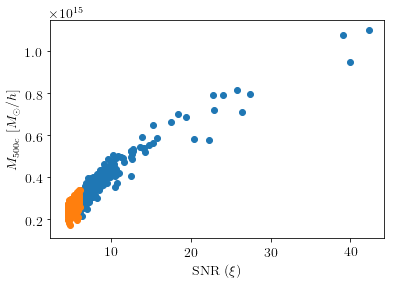

In [4]:
data,h = fitsio.read("2500d_cluster_sample_Bocquet18.fits", header=True)
M500c = data['M500']*1e14 #Msun/h70
#print h #Note - richness is not present
#NOTE: they use h70, not h. This means we need to multiply by h/h70 = 0.7 to get Msun/h
M500c = M500c * hubble
XI = data['XI']
z = data['REDSHIFT']
good = M500c > 0 #Some don't have mass
M500c = M500c[good]
XI = XI[good]
z = z[good]
print(M500c.shape, XI.shape)
hi = XI > 6
lo = XI <= 6
plt.scatter(XI[hi], M500c[hi])
plt.scatter(XI[lo], M500c[lo])
plt.xlabel(r"SNR ($\xi$)")
plt.ylabel(r"$M_{500c}\ [M_\odot/h]$")
plt.savefig("spt_individual_cluster_masses.png", dpi=300, bbox_inches="tight")

In [5]:
#Make a function to compute M200m and c200m
def compute_M200m_and_c200m(M500c, z):
    c500c = concentration.concentration(M500c, '500c', z=z, model='diemer15')
    M200m, R200m, c200m = mass_defs.changeMassDefinition(M500c, c500c, z, '500c', '200m')
    return np.array([M200m, c200m])

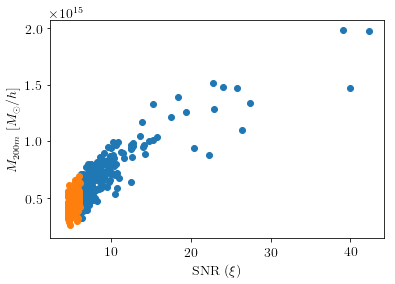

In [6]:
outputs = np.array([compute_M200m_and_c200m(M500c[i], z[i]) for i in range(len(M500c))])
M200m, c200m = outputs.T
plt.scatter(XI[hi], M200m[hi])
plt.scatter(XI[lo], M200m[lo])
_ = plt.xlabel(r"SNR ($\xi$)")
_ = plt.ylabel(r"$M_{200m}\ [M_\odot/h]$")

In [7]:
#Print the mean masses
Mlo = np.mean(M200m[lo])
Mhi = np.mean(M200m[hi])
clo = np.mean(c200m[lo])
chi = np.mean(c200m[hi])
zlo = np.mean(z[lo])
zhi = np.mean(z[hi])
print "Mean mass of xi <= 6 (mean z=%.4f):\n\t%.3e [Msun/h]"%(zlo, Mlo)
print "Mean mass of xi > 6  (mean z=%.4f):\n\t%.3e [Msun/h]"%(zhi, Mhi)

Mean mass of xi <= 6 (mean z=0.5761):
	4.631e+14 [Msun/h]
Mean mass of xi > 6  (mean z=0.5775):
	6.930e+14 [Msun/h]


In [8]:
#Compute the theory correlation functions
r = np.logspace(-2, 2.5, 1000) #Mpc/h comoving
k = np.loadtxt("k.txt") #h/Mpc comoving
Plin = np.loadtxt("plin_z0.58.txt") #(Mpc/h)^3 comoving
Pnl = np.loadtxt("pnl_z0.58.txt")
xilin = ct.xi.xi_mm_at_R(r, k, Plin)
xinl = ct.xi.xi_mm_at_R(r, k, Pnl)

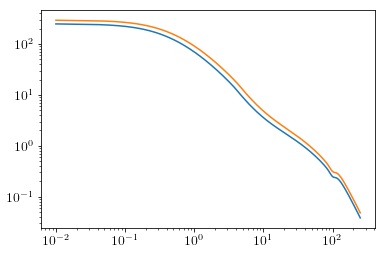

In [9]:
#A function to return the theory DeltaSigma profile
R = np.logspace(-2, 2.4, 1000) #Mpc/h comoving; 2D
def DeltaSigma_from_Mc(M, c):
    xi_nfw   = ct.xi.xi_nfw_at_R(r, M, c, Omega_m)
    bias = ct.bias.bias_at_M(M, k, Plin, Omega_m)
    xi_2halo = ct.xi.xi_2halo(bias, xinl)
    xi_hm    = ct.xi.xi_hm(xi_nfw, xi_2halo)
    Sigma  = ct.deltasigma.Sigma_at_R(R, r, xi_hm, M, c, Omega_m)
    DeltaSigma = ct.deltasigma.DeltaSigma_at_R(R, R, Sigma, M, c, Omega_m)
    return DeltaSigma
#See if any errors pop up
plt.loglog(R, DeltaSigma_from_Mc(Mlo, clo))
plt.loglog(R, DeltaSigma_from_Mc(Mhi, chi))

## DeltaSigmas of clusters of interest

As a first test to visualize things, let's plot theoretical $\Delta\Sigma$ profiles for the first 10 clusters in each of the high and low bins.

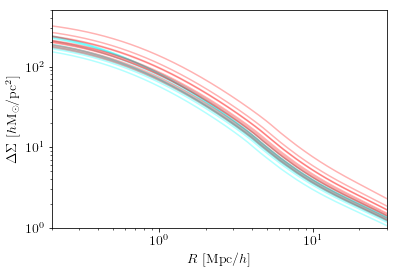

In [10]:
Number_to_plot = 10
for i, (M, c) in enumerate(zip(M200m[lo], c200m[lo])):
    plt.loglog(R, DeltaSigma_from_Mc(M, c), color='cyan', alpha=0.3)
    if i >= Number_to_plot:
        break
for i, (M, c) in enumerate(zip(M200m[hi], c200m[hi])):
    plt.loglog(R, DeltaSigma_from_Mc(M, c), color='red', alpha=0.3)
    if i >= Number_to_plot:
        break
plt.xlim(.2,30)
plt.ylim(1, 500)
_ = plt.xlabel(r"$R\ [{\rm Mpc}/h]$")
_ = plt.ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}]$")

Before we go any farther, let's crack into the data Tamas sent.

In [11]:
#A function for reading in the data

def get_data_from_path(dpath, cpath, hubble=0.7, z=0.577):
    #NOTE: distances are Mpc physical
    Rd, DS, _, _, _ = np.genfromtxt(dpath, unpack=True)
    cov = np.loadtxt(cpath)
    inds = Rd > 0.2
    #cut and convert to Mpc/h comoving and Msun/h
    Rd = Rd[inds] * hubble*(1+z)
    DS = DS[inds] / (hubble*(1+z)**2)
    cov = cov[inds]
    cov = cov[:,inds] / (hubble*(1+z)**2)**2
    err = np.sqrt(cov.diagonal())
    #return Rd, DS, err, cov
    return Rd, DS, err, cov

def get_data(get_lower_half = True):
    i = 0
    if not get_lower_half: i = 1
    dpath = "lensing_data/sz_y1clust_qbin-%d-0_profile.dat"%(i)
    cpath = "lensing_data/sz_y1clust_qbin-%d-0_dst_cov.dat"%(i)
    z = 0.577 #mean z of SPT data
    return get_data_from_path(dpath, cpath, hubble=0.7, z=z)

[]

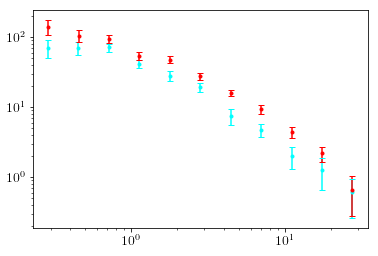

In [12]:
for i, color in zip([True, False], ['cyan', 'red']):
    Rd, DS, err, cov = get_data(i)
    plt.errorbar(Rd, DS, err, color=color, ls='', marker='.')
plt.loglog()

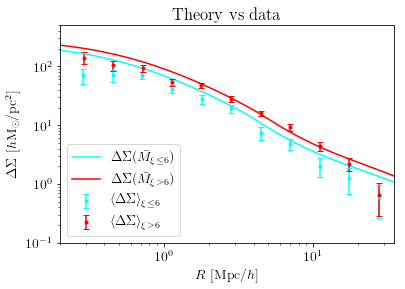

In [13]:
plt.loglog(R, DeltaSigma_from_Mc(Mlo, clo), color='cyan', 
           label=r"$\Delta\Sigma(\bar{M}_{\xi \leq 6})$")
plt.loglog(R, DeltaSigma_from_Mc(Mhi, chi), color='red',
           label=r"$\Delta\Sigma(\bar{M}_{\xi > 6})$")

Rd, DS, err, cov = get_data(True)
plt.errorbar(Rd, DS, err, color='cyan', ls='', marker='.', 
             label=r"$\langle\Delta\Sigma\rangle_{\xi \leq 6}$")
Rd, DS, err, cov = get_data(False)
plt.errorbar(Rd, DS, err, color='red', ls='', marker='.',
            label=r"$\langle\Delta\Sigma\rangle_{\xi > 6}$")

plt.legend()
plt.xlim(.2, 35)
plt.ylim(0.1, 500)
_ = plt.xlabel(r"$R\ [{\rm Mpc}/h]$")
_ = plt.ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}]$")
_ = plt.title("Theory vs data")
plt.savefig("spt_theory_vs_data_old.png", dpi=300, bbox_inches='tight')

## Agreement?

Seems reasonable, but the theory curves *do* seem slightly higher than the data. On the other hand, we know that the cluster masses aren't being weighted correctly when computing $\bar{M}$ for the theory curves.

## SPT vs RM data

In the below plots, I plot the RM vs SPT data, just to double check that the lensing profiles look reasonable.

In [14]:
def get_y1data(zi, lj):
    z = np.loadtxt("lensing_data/Y1_meanz.txt")[zi, lj]
    dpath = "lensing_data/full-unblind-v2-mcal-zmix_y1subtr_l%d_z%d_profile.dat"%(lj, zi)
    cpath = "lensing_data/full-unblind-v2-mcal-zmix_y1subtr_l%d_z%d_dst_cov.dat"%(lj, zi)
    z = 0.577 #mean z of SPT data
    return get_data_from_path(dpath, cpath, hubble=0.7, z=z)

Note: SPT points translated slightly right.


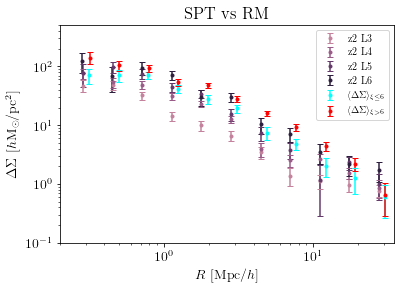

In [15]:
cmap = sns.cubehelix_palette(light=.6, as_cmap=True)
#cmap = mpl.cm.get_cmap('copper')
y1colors = [cmap(i/3.) for i in range(4)]
for zi in [2]:
    for lj in [3,4,5,6]:
        Rd, DS, err, cov = get_y1data(zi, lj)
        plt.errorbar(Rd, DS, err, color=y1colors[lj-3], ls='', marker='.', 
                     label=r"z%d L%d"%(zi, lj))
                     #label=r"$\langle\Delta\Sigma\rangle_{z%dL%d}$"%(zi, lj))
            
Rd, DS, err, cov = get_data(True)
plt.errorbar(Rd*1.1, DS, err, color='cyan', ls='', marker='.', 
             label=r"$\langle\Delta\Sigma\rangle_{\xi \leq 6}$")
Rd, DS, err, cov = get_data(False)
plt.errorbar(Rd*1.1, DS, err, color='red', ls='', marker='.',
            label=r"$\langle\Delta\Sigma\rangle_{\xi > 6}$")

plt.loglog()
plt.legend(fontsize=10)
plt.xlim(.2, 35)
plt.ylim(0.1, 500)
_ = plt.xlabel(r"$R\ [{\rm Mpc}/h]$")
_ = plt.ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}]$")
_ = plt.title("SPT vs RM")
print "Note: SPT points translated slightly right."
plt.savefig("spt_vs_RM.png", dpi=300, bbox_inches='tight')

# Conclusions

So far, it is impossible to say whether the SPT vs RM selections are inconsistent, but it is clear that the weights of the clusters has to be taken into account when computing $\bar{M}$, or else the mass will be overestimated. Note that no systematics are present in the "theory" curve, so no shear or photo-z biases, no miscentering, and no model bias.

## Final result below

The real final result is comparing the averaged $\Delta\Sigma$ profile for each cluster to the data. The next cell computes the lensing profile for the low SNR stack `DSlo` and the lensing profile for the high SNR stack `DShi`. The panel after compares the theory to the data.

Averaged 280 in low stack
Averaged 236 in high stack


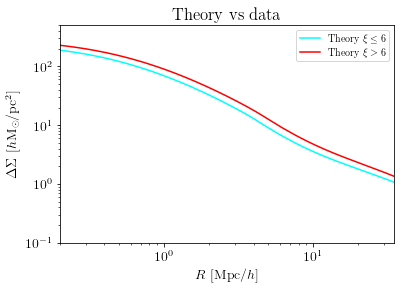

In [16]:
DSlo = DeltaSigma_from_Mc(M200m[0], c200m[0])* 0
DShi = np.zeros_like(DSlo)
N_lo = len(M200m[lo])
N_hi = len(M200m[hi])
print("Averaged %d in low stack"%N_lo)
print("Averaged %d in high stack"%N_hi)

Number_to_average = N_lo
for i, (M, c) in enumerate(zip(M200m[lo], c200m[lo])):
    DSlo += DeltaSigma_from_Mc(M, c)/Number_to_average
    if i >= Number_to_average:
        break

Number_to_average = N_hi
for i, (M, c) in enumerate(zip(M200m[hi], c200m[hi])):
    DShi += DeltaSigma_from_Mc(M, c)/Number_to_average
    if i >= Number_to_average:
        break

plt.loglog(R, DSlo, color='cyan', 
           label=r"Theory $\xi \leq 6$")
plt.loglog(R, DShi, color='red',
           label=r"Theory $\xi > 6$")

plt.legend(fontsize=10)
plt.xlim(.2, 35)
plt.ylim(0.1, 500)
_ = plt.xlabel(r"$R\ [{\rm Mpc}/h]$")
_ = plt.ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}]$")
_ = plt.title("Theory vs data")

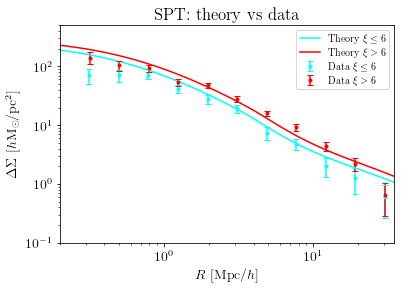

In [17]:
plt.loglog(R, DSlo, color='cyan', 
           label=r"Theory $\xi \leq 6$")
plt.loglog(R, DShi, color='red',
           label=r"Theory $\xi > 6$")

Rd, DS, err, cov = get_data(True)
plt.errorbar(Rd*1.1, DS, err, color='cyan', ls='', marker='.', 
           label=r"Data $\xi \leq 6$")
Rd, DS, err, cov = get_data(False)
plt.errorbar(Rd*1.1, DS, err, color='red', ls='', marker='.',
           label=r"Data $\xi > 6$")

plt.legend(fontsize=10)
plt.xlim(.2, 35)
plt.ylim(0.1, 500)
_ = plt.xlabel(r"$R\ [{\rm Mpc}/h]$")
_ = plt.ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}]$")
_ = plt.title("SPT: theory vs data")
plt.savefig("spt_theory_vs_data.png", dpi=300, bbox_inches='tight')

In [18]:
def compute_chi2(Rdata, DS, Rmodel, DSmodel, C):
    spline = IUS(Rmodel, DSmodel)
    DSm = spline(Rdata) #approximately...
    X = DS - DSm
    return np.dot(X, np.dot(np.linalg.inv(C), X))
Rd, DS, err, cov = get_data(True)
print("(xi <= 6) chi2/DOF = %.3f / %d"%(compute_chi2(Rd, DS, R, DSlo, cov), len(Rd)))

Rd, DS, err, cov = get_data(False)
print("(xi > 6)  chi2/DOF = %.3f / %d"%(compute_chi2(Rd, DS, R, DShi*.85, cov), len(Rd)))

(xi <= 6) chi2/DOF = 141.631 / 11
(xi > 6)  chi2/DOF = 28.111 / 11
